# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

#http://pythondata.com/dask-large-csv-python/
#import dask.dataframe as dd
 
#from collections import Counter
#from patsy import dmatrices
#import statsmodels.api as sm

#https://www.dataquest.io/blog/pandas-big-data/

In [3]:
#Open the dataframe
df = pd.read_pickle('2014_data_LA_SH_V2.pkl')

** Get stats by vessel by month **

** Get voyage stats by month, month will be a proxy for vessel voyage **
- Given the length of vessel voyages between China and California we would not expect to see the same vessel arrive more than once a month, with the possible exception of a vessel that arrives at the beginning of a month and then returns at the end of the month.

In [5]:
#get the unique counts
voyage_stats_all = df.groupby(['vessel_name','month_act']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats_all.reset_index(col_level=1,inplace = True)

In [6]:
voyage_stats_all.shape

(1181, 13)

In [7]:
#view voyage stats in descending order of the number of actual arrival dates per vessel per month
voyage_stats_all.sort_values('actual_arrival_date',ascending = False).head(10)

,vessel_name,month_act,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
998,OOCL KUALA LUMPUR,11,1099,2,1,2,38,22,17,14,976,456,515
555,HANJIN LONG BEACH,10,2382,2,1,2,32,19,18,11,1460,928,1010
991,OOCL ITALY,11,418,2,1,2,17,20,12,11,379,206,225
148,BANGKOK BRIDGE,8,144,2,1,2,18,8,10,10,158,112,124
414,CSCL WINTER,12,377,2,1,2,21,8,19,9,414,245,257
398,CSCL SPRING,12,820,2,1,1,33,10,14,8,1036,464,472
123,BAI CHAY BRIDGE,10,112,1,1,2,13,7,9,8,99,88,88
557,HANJIN LONG BEACH,12,886,2,1,2,27,10,18,8,880,462,493
421,CSCL YELLOW SEA,12,927,2,1,2,32,12,16,7,1106,526,515
300,COSCO EUROPE,10,1869,2,1,2,35,27,20,7,1033,710,744


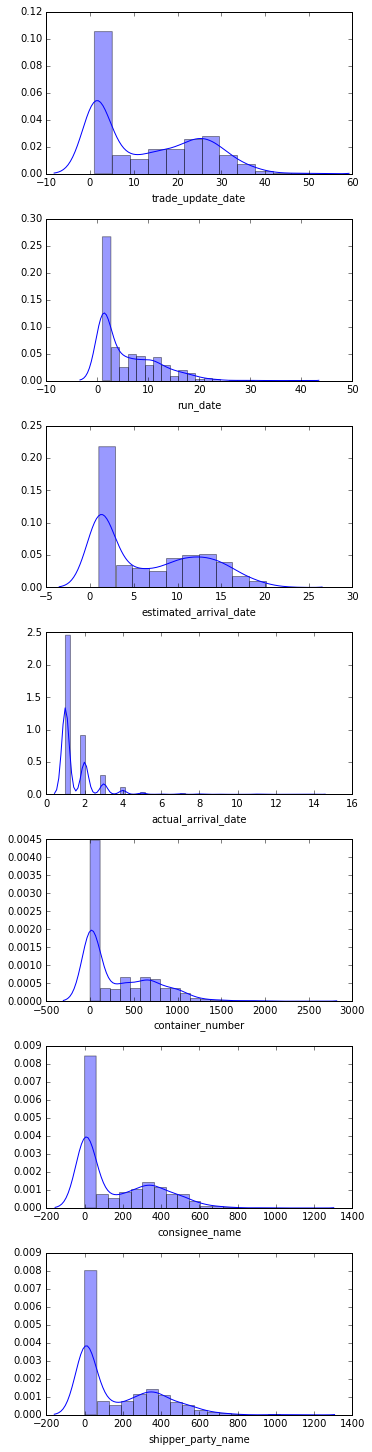

In [11]:
#view all distributions
n = 0
fig, axs = plt.subplots(nrows =7,figsize=(5,20))
for i,x in enumerate(list(voyage_stats_all)[6:]): 
    sns.distplot(voyage_stats_all[x], ax=axs[i])
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
#sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])
#sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])

** View distributions of number of estimated and actual arrival date by vessel for each month **

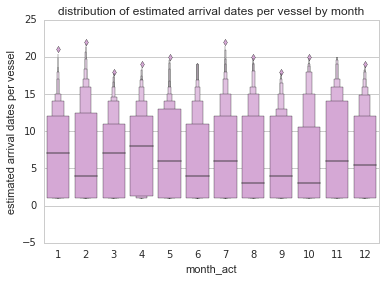

In [12]:
#view the distribution by month of estimated arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="estimated_arrival_date", data=voyage_stats_all, color = 'plum')
ax.set_ylabel('estimated arrival dates per vessel')
ax.set_title('distribution of estimated arrival dates per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

[(0, 60)]

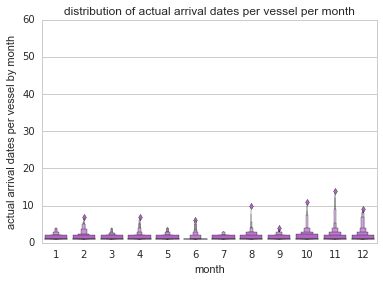

In [13]:
#view the distribution by month of actual arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="actual_arrival_date", data=voyage_stats_all, color = 'mediumorchid')
ax.set_xlabel('month')
ax.set_ylabel('actual arrival dates per vessel by month')
ax.set_title('distribution of actual arrival dates per vessel per month')
ax.set(ylim=(0, 60))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

** Compute the correlation between the number of arrival dates per ship and the number of containers per ship **

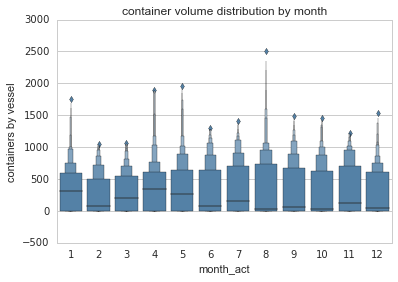

In [15]:
#view the distribution of containers per ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="container_number", data=voyage_stats_all, color = 'steelblue')
ax.set_ylabel('containers by vessel')
ax.set_title('container volume distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [16]:
#average actual arrival dates per vessel
print voyage_stats_all.actual_arrival_date.mean()

#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]) / (len(voyage_stats_all) * 1.0)

#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]) / (len(voyage_stats_all) * 1.0)

1.59864521592
148 1181
0.125317527519
14 1181
0.0118543607113


In [17]:
#average estimated arrival dates per vessel
print voyage_stats_all.estimated_arrival_date.mean()

#estimated arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]) / (len(voyage_stats_all) * 1.0)

#estimated arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]) / (len(voyage_stats_all) * 1.0)

6.83488569009
584 1181
0.49449618967
383 1181
0.324301439458


In [18]:
#Correlation between the number of actual_arrival_dates and number of containers per ship per month
voyage_stats_all['actual_arrival_date'].corr(voyage_stats_all['container_number'])

0.38655931309345848

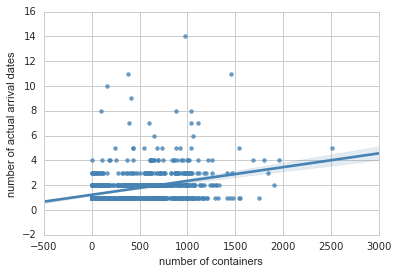

In [19]:
#show the relationship between volume and the number of actual arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="actual_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of actual arrival dates')

In [20]:
#Correlation between the number of estimated_arrival_dates and number of containers per ship per month
voyage_stats_all['estimated_arrival_date'].corr(voyage_stats_all['container_number'])

0.88789282764940547

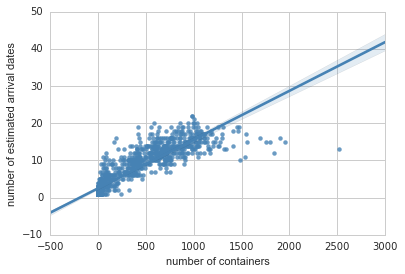

In [21]:
#show the relationship between volume and the number of estimated arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="estimated_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of estimated arrival dates')

** Consolidate observations by identifier ** 

description text won't be analyzed for this analysis and it is beyond the scope

In [36]:
list(df)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'actual_arrival_date',
 'consignee_name',
 'shipper_party_name',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'carrier',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'vessel_name']

In [58]:
#set up the groupby and count fields
df_count = df[['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
          'port_of_unlading','estimated_arrival_date','actual_arrival_date','foreign_port_of_lading',
          'record_status_indicator','place_of_receipt','day_of_week_est','day_of_week_act','month_est',
          'month_act','delay_days','consignee_name','shipper_party_name','container_number',
          'description_sequence_number']]

df_sum = df[['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
          'port_of_unlading','estimated_arrival_date','actual_arrival_date','foreign_port_of_lading',
          'record_status_indicator','place_of_receipt','day_of_week_est','day_of_week_act','month_est',
          'month_act','delay_days','piece_count']]

id_groupby_fields = ['identifier','trade_update_date','run_date','vessel_name_orig','vessel_name','carrier',
                     'port_of_unlading','estimated_arrival_date','actual_arrival_date','foreign_port_of_lading',
                     'record_status_indicator','place_of_receipt','day_of_week_est','day_of_week_act','month_est',
                     'month_act','delay_days']

In [64]:
#Need to do count and sum separately
df2 = df_count.groupby(id_groupby_fields,as_index=False).agg(['count'])

In [65]:
df2_sum = df_sum.groupby(id_groupby_fields,as_index=False).agg(['sum'])

In [66]:
#reformat columns
df2.columns = ['_'.join(tup).rstrip('_') for tup in df2.columns.values]
df2.reset_index(col_level=1,inplace = True)

df2_sum.columns = ['_'.join(tup).rstrip('_') for tup in df2_sum.columns.values]
df2_sum.reset_index(col_level=1,inplace = True)


In [67]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,...,place_of_receipt,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,consignee_name_count,shipper_party_name_count,container_number_count,description_sequence_number_count
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",...,SHANGHAI,2,3,2,2,1,0,0,1,1
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,SHANGHAI,1,5,2,2,4,1,1,1,1
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,SHANGHAI,1,5,2,2,4,0,0,1,1
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",...,SHANGHAI,6,6,5,5,0,1,1,1,1
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",...,"JIANGYIN, CHINA",3,3,5,5,7,14,14,14,14


In [68]:
df2_sum.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,piece_count_sum
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",Amended,SHANGHAI,2,3,2,2,1,126
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",Amended,SHANGHAI,1,5,2,2,4,1000
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",Amended,SHANGHAI,1,5,2,2,4,2079
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",Amended,SHANGHAI,6,6,5,5,0,14
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",Amended,"JIANGYIN, CHINA",3,3,5,5,7,196


In [70]:
#merge the sum into df2
df2 = df2.merge(df2_sum, on = id_groupby_fields, how = 'left')

In [71]:
df2.shape, df.shape

((374871, 22), (658583, 25))

In [72]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name_orig,vessel_name,carrier,port_of_unlading,estimated_arrival_date,actual_arrival_date,foreign_port_of_lading,...,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,consignee_name_count,shipper_party_name_count,container_number_count,description_sequence_number_count,piece_count_sum
0,201406038,2014-01-16,2014-06-03,HANJIN KOREA,HANJIN KOREA,HANJIN,"Long Beach, California",2014-02-05,2014-02-06,"Shanghai ,China (Mainland)",...,2,3,2,2,1,0,0,1,1,126
1,201406058,2014-01-30,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,1,5,2,2,4,1,1,1,1,1000
2,201406059,2014-01-28,2014-06-05,CMACGM DONGIOVANNI,CMACGM DONGIOVANNI,CMACGM,"Long Beach, California",2014-02-18,2014-02-22,"Shanghai ,China (Mainland)",...,1,5,2,2,4,0,0,1,1,2079
3,201411248,2014-05-08,2014-11-24,CSCL SUMMER,CSCL SUMMER,CSCL,"Los Angeles, California",2014-05-25,2014-05-25,"Shanghai ,China (Mainland)",...,6,6,5,5,0,1,1,1,1,14
4,201412018,2014-04-23,2014-12-01,HANJIN CHINA,HANJIN CHINA,HANJIN,"Los Angeles, California",2014-05-08,2014-05-15,"Shanghai ,China (Mainland)",...,3,3,5,5,7,14,14,14,14,196


** Set up the initial features and look for correlations **

In [73]:
list(df2)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name_orig',
 'vessel_name',
 'carrier',
 'port_of_unlading',
 'estimated_arrival_date',
 'actual_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'consignee_name_count',
 'shipper_party_name_count',
 'container_number_count',
 'description_sequence_number_count',
 'piece_count_sum']

In [89]:
df_features = df2[['record_status_indicator','delay_days','month_est','day_of_week_est','consignee_name_count',
                  'shipper_party_name_count','container_number_count',
                  'description_sequence_number_count','piece_count_sum']]

In [90]:
#one hot encode variables
df_features = pd.get_dummies(df_features,columns=['record_status_indicator','month_est',
                                                 'day_of_week_est'])

In [91]:
#drop record status deleted (records with a deleted status were dropped earlier in the analysis)
df_features.drop('record_status_indicator_Deleted',1,inplace = True)

In [92]:
list(df_features)

['delay_days',
 'consignee_name_count',
 'shipper_party_name_count',
 'container_number_count',
 'description_sequence_number_count',
 'piece_count_sum',
 'record_status_indicator_Amended',
 'record_status_indicator_New',
 'month_est_1',
 'month_est_2',
 'month_est_3',
 'month_est_4',
 'month_est_5',
 'month_est_6',
 'month_est_7',
 'month_est_8',
 'month_est_9',
 'month_est_10',
 'month_est_11',
 'month_est_12',
 'day_of_week_est_0',
 'day_of_week_est_1',
 'day_of_week_est_2',
 'day_of_week_est_3',
 'day_of_week_est_4',
 'day_of_week_est_5',
 'day_of_week_est_6']

In [93]:
df_features.head()

,delay_days,consignee_name_count,shipper_party_name_count,container_number_count,description_sequence_number_count,piece_count_sum,record_status_indicator_Amended,record_status_indicator_New,month_est_1,month_est_2,...,month_est_10,month_est_11,month_est_12,day_of_week_est_0,day_of_week_est_1,day_of_week_est_2,day_of_week_est_3,day_of_week_est_4,day_of_week_est_5,day_of_week_est_6
0,1,0,0,1,1,126,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,4,1,1,1,1,1000,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,4,0,0,1,1,2079,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0,1,1,1,1,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,7,14,14,14,14,196,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [94]:
#create a pairwise correlation matrix
df_corr = df_features.corr()

In [95]:
df_corr

,delay_days,consignee_name_count,shipper_party_name_count,container_number_count,description_sequence_number_count,piece_count_sum,record_status_indicator_Amended,record_status_indicator_New,month_est_1,month_est_2,...,month_est_10,month_est_11,month_est_12,day_of_week_est_0,day_of_week_est_1,day_of_week_est_2,day_of_week_est_3,day_of_week_est_4,day_of_week_est_5,day_of_week_est_6
delay_days,1.000000,0.005355,0.005108,0.005883,0.005883,0.006223,-0.180903,0.180903,-0.005153,-0.101361,...,0.059663,0.160344,0.063897,0.022011,0.013237,0.029023,-0.087991,0.033395,0.013784,-0.028150
consignee_name_count,0.005355,1.000000,0.991512,0.970575,0.970575,0.137621,0.010989,-0.010989,-0.003475,-0.013161,...,-0.016009,-0.014243,-0.009789,0.007140,0.008878,-0.014853,-0.014187,0.000749,0.005626,0.008998
shipper_party_name_count,0.005108,0.991512,1.000000,0.962354,0.962354,0.137152,0.012317,-0.012317,-0.002988,-0.013232,...,-0.016073,-0.014313,-0.009912,0.005670,0.009210,-0.014419,-0.014968,0.001120,0.006162,0.009591
container_number_count,0.005883,0.970575,0.962354,1.000000,1.000000,0.144329,0.007823,-0.007823,-0.000197,-0.011320,...,-0.014707,-0.014786,-0.011741,0.012700,0.008101,-0.016029,-0.013336,0.003278,0.005321,0.002773
description_sequence_number_count,0.005883,0.970575,0.962354,1.000000,1.000000,0.144329,0.007823,-0.007823,-0.000197,-0.011320,...,-0.014707,-0.014786,-0.011741,0.012700,0.008101,-0.016029,-0.013336,0.003278,0.005321,0.002773
piece_count_sum,0.006223,0.137621,0.137152,0.144329,0.144329,1.000000,-0.009828,0.009828,0.009796,-0.006105,...,-0.008112,-0.007375,-0.003381,0.001483,-0.000432,0.000259,-0.006360,-0.005415,0.000098,0.009051
record_status_indicator_Amended,-0.180903,0.010989,0.012317,0.007823,0.007823,-0.009828,1.000000,-1.000000,0.004573,0.025922,...,0.039181,0.013645,-0.064171,-0.099983,0.015762,0.061872,-0.005369,0.066045,0.008010,-0.046530
record_status_indicator_New,0.180903,-0.010989,-0.012317,-0.007823,-0.007823,0.009828,-1.000000,1.000000,-0.004573,-0.025922,...,-0.039181,-0.013645,0.064171,0.099983,-0.015762,-0.061872,0.005369,-0.066045,-0.008010,0.046530
month_est_1,-0.005153,-0.003475,-0.002988,-0.000197,-0.000197,0.009796,0.004573,-0.004573,1.000000,-0.084067,...,-0.099841,-0.098980,-0.081221,-0.025291,-0.015446,0.034898,-0.005184,-0.010601,0.073537,-0.036805
month_est_2,-0.101361,-0.013161,-0.013232,-0.011320,-0.011320,-0.006105,0.025922,-0.025922,-0.084067,1.000000,...,-0.081923,-0.081217,-0.066644,0.004989,-0.002292,0.004009,0.011857,-0.035420,0.051202,-0.019023


In [96]:
df_corr[['delay_days']]

,delay_days
delay_days,1.000000
consignee_name_count,0.005355
shipper_party_name_count,0.005108
container_number_count,0.005883
description_sequence_number_count,0.005883
piece_count_sum,0.006223
record_status_indicator_Amended,-0.180903
record_status_indicator_New,0.180903
month_est_1,-0.005153
month_est_2,-0.101361


** Additional features to consider if more features are needed **

month of run_date  
month of trade_update_date  
carrier: top 5/top 10 by volume (binary variable)  
place_of_receipt: if there is some way to group these into categories  